Trained on Collab

In [27]:
%matplotlib inline

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [30]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0) # adding a 1 in Batch Dimension for VGG model
    return image.to(device, torch.float)


style_img = image_loader("/content/test.jpg") # add the path of image according to it
content_img = image_loader("/content/horse.jpg")


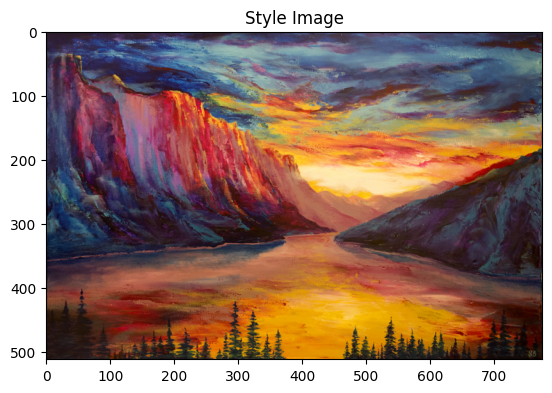

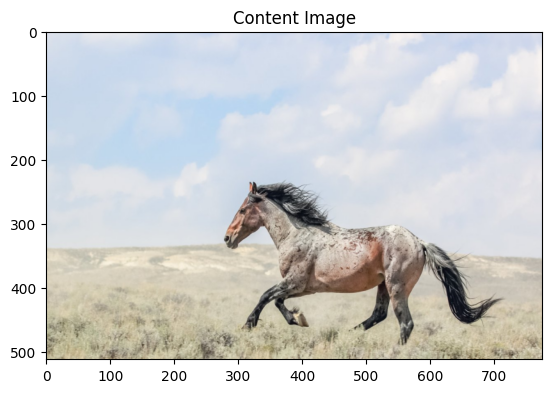

In [31]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)   # Remove the added batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [68]:
#Measure the pixel difference between the generated image and actual Content image . Pixel wise difference for acurate mimic of shape in images
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [33]:
# Gram matrix for the style loss. How each filter is aligned with other feature map (filter map) each [i][j] -> tells how each filter i is aligned with filter j
# Output will be (C,C) where C is number of filters of Conv layer

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)  # resizing for product
    G = torch.mm(features, features.t())
    #'normalize' the values of the gram matrix
    return G.div(a * b * c * d)

In [34]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target) # computing loss between given style image and style of generated
        return input

In [35]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [69]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [70]:
test = nn.Sequential()
i = 0
for layer in cnn.children():
  if isinstance(layer, nn.Conv2d):
    i+=1
    test.add_module("conv_{}".format(i), layer)
#print(test)

In [36]:
# Mean and standard deviation of Image Net data as VGG was trained on it . Hardcoding this
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [37]:
# Using these feature Map of Conv layer As for content we know from low -> high conv layer stack it goes from edges -> high feature finding so
# picking in between
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    # as VGG net (cnn) is sequential
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i).
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # stacking up the layers for own model
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

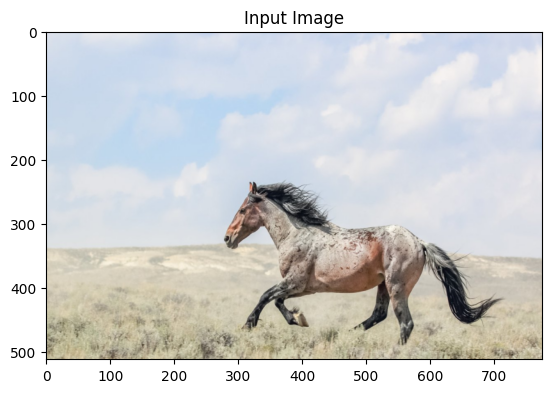

In [38]:
input_img = content_img.clone() # Cloning with initial one or can do white out as well

plt.figure()
imshow(input_img, title='Input Image')

In [49]:
def get_input_optimizer(input_img):
    optimizer = optim.Adam([input_img]) # or optim.LBFGS
    return optimizer

In [57]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=600,
                       style_weight=1000000, content_weight=100): # hyper parameters

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)

    model.eval() # -> for batch norm layer for inference and use running mean and std and for dropout
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 100.277367 Content Loss: 414.602081

run [100]:
Style Loss : 100.289909 Content Loss: 414.550110

run [150]:
Style Loss : 100.290260 Content Loss: 414.540619

run [200]:
Style Loss : 100.287132 Content Loss: 414.532745

run [250]:
Style Loss : 100.285225 Content Loss: 414.521118

run [300]:
Style Loss : 100.282822 Content Loss: 414.508911

run [350]:
Style Loss : 100.281265 Content Loss: 414.494385

run [400]:
Style Loss : 100.285225 Content Loss: 414.473724

run [450]:
Style Loss : 100.287231 Content Loss: 414.454071

run [500]:
Style Loss : 100.287460 Content Loss: 414.436249

run [550]:
Style Loss : 100.268509 Content Loss: 414.436829

run [600]:
Style Loss : 100.277313 Content Loss: 414.409790



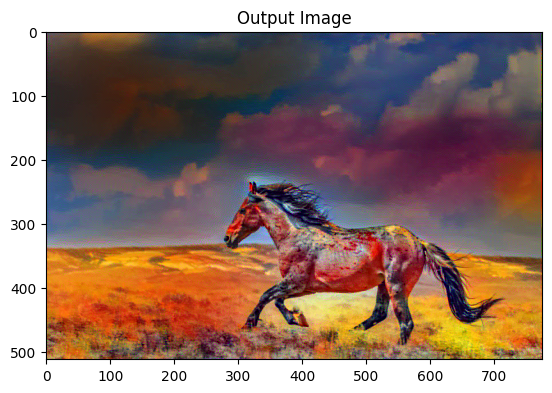

In [66]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

In [67]:
# from torchvision.utils import save_image

# save_image(output.clamp(0, 1), 'stylized_output.png')

